#  💭 Aspect-Based Sentiment Analysis with Setfit ABSA and Argilla

In this tutorial, we will fine-tune a pre-trained model for binary Aspect-Based Sentiment Analysis (ABSA) using the **Setfit ABSA** library. Then, we will make some predictions and evaluate the results using **Argilla**.

We will follow these steps:

- Prepare the dataset with the required format.
- Fine-tune using Setfit ABSA.
- Predict and evaluate the results using Argilla.
- (Extra) Format back your annotations for Setfit ABSA.

## Introduction

Sentiment analysis is an effective natural language processing approach for assessing the emotional tone of text. However, measuring the overall sentiment can be challenging. **Aspect-Based Sentiment Analysis (ABSA)** refines this task by classifying sentiments toward different detected aspects within the text. For instance, consider the sentence "The food was great, but the service was terrible". In this case, ABSA identifies the positive sentiment toward "food" and the negative sentiment toward "service. This nuanced approach provides a detailed understanding of the sentiment, which is invaluable for capturing consumers' more subtle opinions about specific products or services.

Normally, ABSA can be divided into three main steps:

1. **Aspect Extraction**: This stage involves identifying potential aspects or entities mentioned in the text. In the sentence "The food was great, but the service was terrible", the aspects are "food" and "service".
2. **Aspect Classification**: This involves verifying the accuracy of the identified aspects. That is, if "food" and "service" are indeed the aspects that need to be analyzed.
3. **Polarity Classification**: This step involves assessing the sentiment associated with each identified aspect. What is the sentiment toward "food" and "service"?

However, [Setfit ABSA](https://huggingface.co/blog/setfit-absa) simplifies this process by combining the aspect and polarity classification steps into a single step. This tutorial will explore the specifics of this simplified approach.


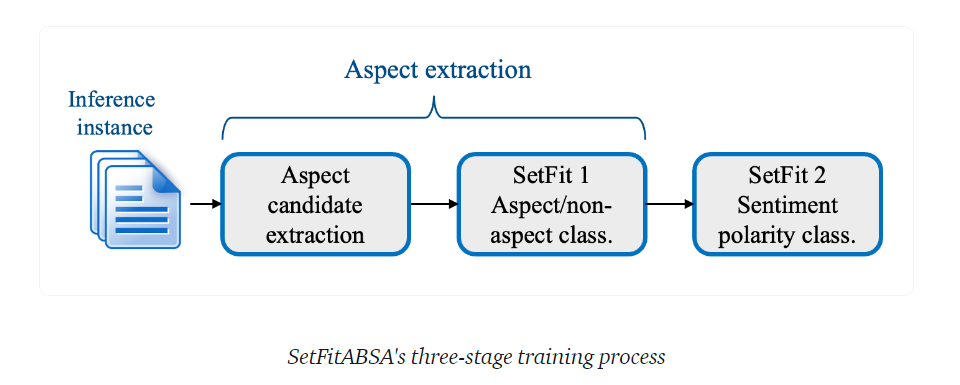

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:


**Deploy Argilla on Hugging Face Spaces**: If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/login?next=%2Fnew-space%3Ftemplate%3Dargilla%2Fargilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).


**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../getting_started/quickstart.html). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or a Jupyter Notebook tool of your choice.
</div>

## Set up the Environment

To complete this tutorial, you will need to install the Argilla client and a few third-party libraries using `pip`:

In [ ]:
%pip install argilla setfit[absa] spacy
# %pip install --upgrade huggingface_hub # Uncomment this line if you are not using the latest version of huggingface_hub

!spacy download en_core_web_lg

Let's make the needed imports:

In [ ]:
import argilla as rg
import spacy
from datasets import load_dataset, Dataset
from setfit import AbsaTrainer, AbsaModel, TrainingArguments
from argilla.client.feedback.schemas import SpanValueSchema

If you are running Argilla using the Docker quickstart image or a public Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [2]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
# Replace workspace with the name of your workspace
rg.init(
    api_url="http://localhost:6900", 
    api_key="argilla.apikey",
    workspace="argilla"
)

If you're running a private Hugging Face Space, you will also need to set the [HF_TOKEN](https://huggingface.co/settings/tokens) as follows:

In [ ]:
# # Set the HF_TOKEN environment variable
# import os
# os.environ['HF_TOKEN'] = "your-hf-token"

# # Replace api_url with the url to your HF Spaces URL
# # Replace api_key if you configured a custom API key
# rg.init(
#     api_url="https://[your-owner-name]-[your_space_name].hf.space", 
#     api_key="admin.apikey",
#     extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"},
# )

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running
    tutorial_running()
except ImportError:
    print("Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry.")

## Preparing the Dataset

For our ABSA task, we will use [semeval-absa](https://huggingface.co/datasets/jakartaresearch/semeval-absa), a dataset from [SemEval-2015 Task 12](https://alt.qcri.org/semeval2015/task12/) with aspect-based sentiment analysis annotations. It contains reviews from the restaurant and laptop domains, although we will focus on the restaurant domain for this tutorial.

First, let's load the dataset and display some examples.

In [4]:
# Load the dataset
hf_dataset = load_dataset("jakartaresearch/semeval-absa", "restaurant", split="train", trust_remote_code=True)
hf_dataset[0]

{'id': '3121',
 'text': 'But the staff was so horrible to us.',
 'aspects': {'term': ['staff'],
  'polarity': ['negative'],
  'from': [8],
  'to': [13]},
 'category': {'category': ['service'], 'polarity': ['negative']}}

Next, we will just randomly select 150 examples from the dataset and split them into training and validation sets.

In [5]:
# Sample the dataset
hf_dataset_sample = hf_dataset.shuffle(seed=5).select(range(150))

In [11]:
# Split the dataset into training and development sets
train_eval_split = hf_dataset_sample.train_test_split(test_size=0.3)

# Converting the training and development datasets to pandas DataFrames
train_df = train_eval_split['train'].to_pandas()
eval_df = train_eval_split['test'].to_pandas()

Now, it's time to format the dataset for Setfit ABSA. The datasets should have four columns: `text`, `span`, `label`, and `ordinal`. The `text` column contains the text to be analyzed, `span` is the aspect, `label` refers to the sentiment of the aspect, and `ordinal` indicates the index of the span occurrence if appears multiple times. So, what about if a review has multiple aspects? In this case, we will duplicate the review for each aspect. For instance,

* `text`: "The food was great, but the service was terrible" , `span`: "food", `label`: "positive", `ordinal`: 0
* `text`: "The food was great, but the service was terrible" , `span`: "service", `label`: "negative", `ordinal`: 0

In [12]:
# Helper function to calculate the ordinal of the term in the text
def calculate_ordinal(text, term, from_index):
    ordinal = 0
    start = 0
    
    while start < from_index:
        found_index = text.find(term, start)
        if found_index == -1 or found_index >= from_index:
            break  
        ordinal += 1
        start = found_index + len(term)
    return ordinal

# Function to prepare the dataset for training
def prepare_dataset(df):
    prepared_data = []
    for _, row in df.iterrows():
        text, aspects = row['text'], row['aspects']
        for term, polarity, start_index in zip(aspects['term'], aspects['polarity'], aspects['from']):
            if polarity not in ['positive', 'negative']: # Skip neutral polarity
                continue
            prepared_data.append({
                "text": text,
                "span": term,
                "label": polarity,
                "ordinal": calculate_ordinal(text, term, start_index)
            })
    return prepared_data

# Helper function to convert a list of dictionaries to a dictionary of lists
def list_dict_to_dict_list(list_dict):
    return {key: [dic[key] for dic in list_dict] for key in list_dict[0]}

In [13]:
# Formatting the data
prepared_data_train = prepare_dataset(train_df)
prepared_data_eval = prepare_dataset(eval_df)

# Creating Datasets
train_dataset = Dataset.from_dict(list_dict_to_dict_list(prepared_data_train))
eval_dataset = Dataset.from_dict(list_dict_to_dict_list(prepared_data_eval))

In [14]:
train_dataset, eval_dataset

(Dataset({
     features: ['text', 'span', 'label', 'ordinal'],
     num_rows: 90
 }),
 Dataset({
     features: ['text', 'span', 'label', 'ordinal'],
     num_rows: 47
 }))

Finally, we have our dataset ready for training.

In [15]:
train_dataset.to_pandas().head()

,text,span,label,ordinal
0,Not too crazy about their sake martini.,sake martini,negative,0
1,"Solid wine list, knowledgeable staff, friendly...",wine list,positive,0
2,"Solid wine list, knowledgeable staff, friendly...",staff,positive,0
3,"Solid wine list, knowledgeable staff, friendly...",owners,positive,0
4,"Solid wine list, knowledgeable staff, friendly...",menu,positive,0


## Training with Setfit ABSA

As we mentioned earlier, [Setfit ABSA](https://huggingface.co/docs/setfit/en/how_to/absa#setfit-for-aspect-based-sentiment-analysis) simplifies the ABSA task by combining the aspect and polarity classification steps into a single step. In addition, as it is based on the [SetFit](https://huggingface.co/models?pipeline_tag=setfit) architecture, it is a few-shot model that can be fine-tuned with a few examples.

The training process takes over 15 minutes to complete depending on the computing capabilities of your machine and the set training parameters. However, we highly recommend using a GPU to speed up the training process.

In [ ]:
# Check your GPU availability
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead.")

The training is straightforward. Initially, we need to load the Sentence Transformers models to be used for aspect and polarity classification. It's possible to use the same model for both tasks or opt for different models for each. By default, the spaCy model employed for aspect extraction is `en_core_web_lg`, although others can be used.

> We will use the default arguments for both tasks. However, you can customize them for each one by setting `polarity_args`. For more information, check the [Setfit ABSA documentation](https://huggingface.co/docs/setfit/v1.0.3/en/reference/trainer#setfit.AbsaTrainer).

In [ ]:
# Load the models
model = AbsaModel.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2",
    "sentence-transformers/paraphrase-MiniLM-L6-v2",
    spacy_model="en_core_web_lg",
)

# Define the training arguments
args = TrainingArguments(
    output_dir="models",
    num_epochs=1,
    batch_size=16,
    evaluation_strategy="steps",
)

Let's train the model!

In [ ]:
# Initialize the trainer
trainer = AbsaTrainer(
    model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)
trainer.train()

Now, we can evaluate the model on the eval dataset. The output will indicate the accuracy of the aspect and polarity classification tasks.

In [24]:
# Evaluate the model
metrics = trainer.evaluate(eval_dataset)
metrics

***** Running evaluation *****
***** Running evaluation *****


{'aspect': {'accuracy': 0.8235294117647058}, 'polarity': {'accuracy': 0.9090909090909091}}


In [23]:
# Save the classification models locally or push them to the Hub
model.save_pretrained(
    "models/setfit-absa-aspect", 
    "models/setfit-absa-polarity"
)

# model.push_to_hub(
#     "[hf-repo]/setfit-absa-aspect",
#     "[hf-repo]/setfit-absa-polarity"
# )

## Inferring with our model

The results are promising! Now, let's make some predictions using the trained model.

For our testing data, we'll employ 50 examples from a distinct dataset from the same domain, [filtered_yelp_restaurant_reviews](https://huggingface.co/datasets/vincha77/filtered_yelp_restaurant_reviews). This dataset includes the overall sentiment for each review, enabling us to create a comprehensive dataset that supports both ABSA and general sentiment analysis.

In [18]:
# Load the test dataset
test_dataset = load_dataset("vincha77/filtered_yelp_restaurant_reviews", split="test")

In [19]:
# Sample the test dataset
test_dataset_sample = test_dataset.shuffle(seed=5).select(range(20))
test_dataset_sample

Dataset({
    features: ['text', 'label', 'review_length'],
    num_rows: 20
})

In [20]:
# Define the sentences and labels
labels = [label for label in test_dataset_sample['label']]
sentences = [text for text in test_dataset_sample['text']]

# Helper dictionaries
id2label_overall = {0: "NEG", 1: "NEU", 2: "POS"}
id2label_span = {"negative": "NEG", "positive": "POS"}

In [21]:
sentences[0], labels[0]

("I'm spoiled when it comes to Chinese food because I work in University City and can have my favorite Chinese whenever I want it. I'm giving King's a somewhat generous four stars with the understanding that they are pretty good for being outside of center city's limits.\n\nMy husband and I split a takeout order of cashew chicken (tasty but the celery was weird and raw), steamed vegetable dumplings (a bit on the doughy side but okay) and vegetable lo mein (pretty nice). Overall, the meal was around $20 and way more than enough for two people with lots of leftovers. It's definitely a great value. I think we've found our local Chinese takeout spot. What should we order next?",
 2)

Once, we have the testing data, we can make predictions using the trained models. The predictions will include the aspect and sentiment for each span.

In [ ]:
# Load the models
model = AbsaModel.from_pretrained(
    "models/setfit-absa-model-aspect", 
    "models/setfit-absa-model-polarity"
)

# Make predictions
predictions = model.predict(sentences)

In [23]:
predictions[0]

[{'span': 'food', 'polarity': 'positive'},
 {'span': 'takeout order', 'polarity': 'positive'},
 {'span': 'cashew chicken', 'polarity': 'positive'},
 {'span': 'celery', 'polarity': 'positive'},
 {'span': 'vegetable dumplings', 'polarity': 'positive'},
 {'span': 'vegetable lo mein', 'polarity': 'positive'},
 {'span': 'meal', 'polarity': 'positive'},
 {'span': 'people', 'polarity': 'positive'},
 {'span': 'leftovers', 'polarity': 'positive'},
 {'span': 'value', 'polarity': 'positive'},
 {'span': 'takeout spot', 'polarity': 'positive'}]

### Evaluating the Predictions

Finally, we can use Argilla to assess the model's predictions. Monitoring the model's performance is crucial for detecting areas that require enhancement or for the creation of a new ABSA dataset. For example, in our scenario, the reviews in the testing dataset are longer than those in the training set, a factor that could influence the model's effectiveness.

Thus, we create a Feedback dataset with a `SpanQuestion` for the aspect, another `SpanQuestion` for the sentiment, and a `LabelQuestion` for the overall sentiment. Check the [Argilla documentation](../../../practical_guides/create_update_dataset/create_dataset.html#define-questions) for more information on creating Feedback datasets and the new Span Question.

In [ ]:
# Define the feedback dataset
rg_dataset = rg.FeedbackDataset(
    fields=[
        rg.TextField(name="text"),
        rg.TextField(name="aspect"),
        rg.TextField(name="polarity"),
    ],
    questions=[
        rg.LabelQuestion(
            name="overall-sentiment",
            title="What is the overall sentiment of the text?",
            labels={"POS": "Positive", "NEU":"Neutral", "NEG": "Negative"},
            required=True,
        ),
        rg.SpanQuestion(
            name="aspect",
            title="Highlight the aspects in the text:",
            labels={"ASP"},
            field="aspect",
            required=True
        ),
        rg.SpanQuestion(
            name="polarity",
            title="Highlight the polarity of the aspects in the text:",
            labels={"POS", "NEG"},
            field="polarity",
            required=True
        ),
    ],
    guidelines="Please, read the question carefully and try to answer it as accurately as possible."
)
rg_dataset = rg_dataset.push_to_argilla(name="absa-dataset", workspace="argilla")

Then, we have to add the records to our Feedback dataset. The predictions will be added as responses to facilitate the annotators' work.

> Remember that as they are added as responses, the records will appear as `submitted`.

In [25]:
# Helper function to find the span indices in the sentence and return a list of SpanValueSchema objects
nlp = spacy.load("en_core_web_lg")

def find_span_indices(sentence, predictions, aspect=True):
    doc = nlp(sentence)
    found_spans = []
    
    last_found_index = {span['span']: -1 for span in predictions}
    
    for span_dict in predictions:
        span_text = span_dict['span']
        found = False

        for i in range(len(doc)):
            window_text = " ".join(doc[j].text for j in range(i, min(i + len(span_text.split()), len(doc))))
            
            if window_text == span_text and i > last_found_index[span_text]:
                start_index = doc[i].idx
                end_index = doc[i + len(span_text.split()) - 1].idx + len(doc[i + len(span_text.split()) - 1])
                
                found_spans.append(SpanValueSchema(start=start_index, end=end_index, 
                                                label="ASP" if aspect else id2label_span[span_dict['polarity']]))
                last_found_index[span_text] = i
                found = True
                break
        if not found:
            raise ValueError(f"Span '{span_text}' not found in the sentence.")
        
    return found_spans

In [ ]:
# Add the records to the dataset
records = [
    rg.FeedbackRecord(
        fields={
            "text": sentence, 
            "aspect": sentence, 
            "polarity": sentence
        },
        responses=[
            {
                "values": {
                    "overall-sentiment": {
                        "value": id2label_overall[label]
                    },
                    "aspect": {
                        "value": find_span_indices(sentence, prediction, aspect=True),
                    },
                    "polarity": {
                        "value": find_span_indices(sentence, prediction, aspect=False),
                    },
                }
            }
        ]
    )
    for sentence, prediction, label in zip(sentences, predictions, labels)
]
rg_dataset.add_records(records)

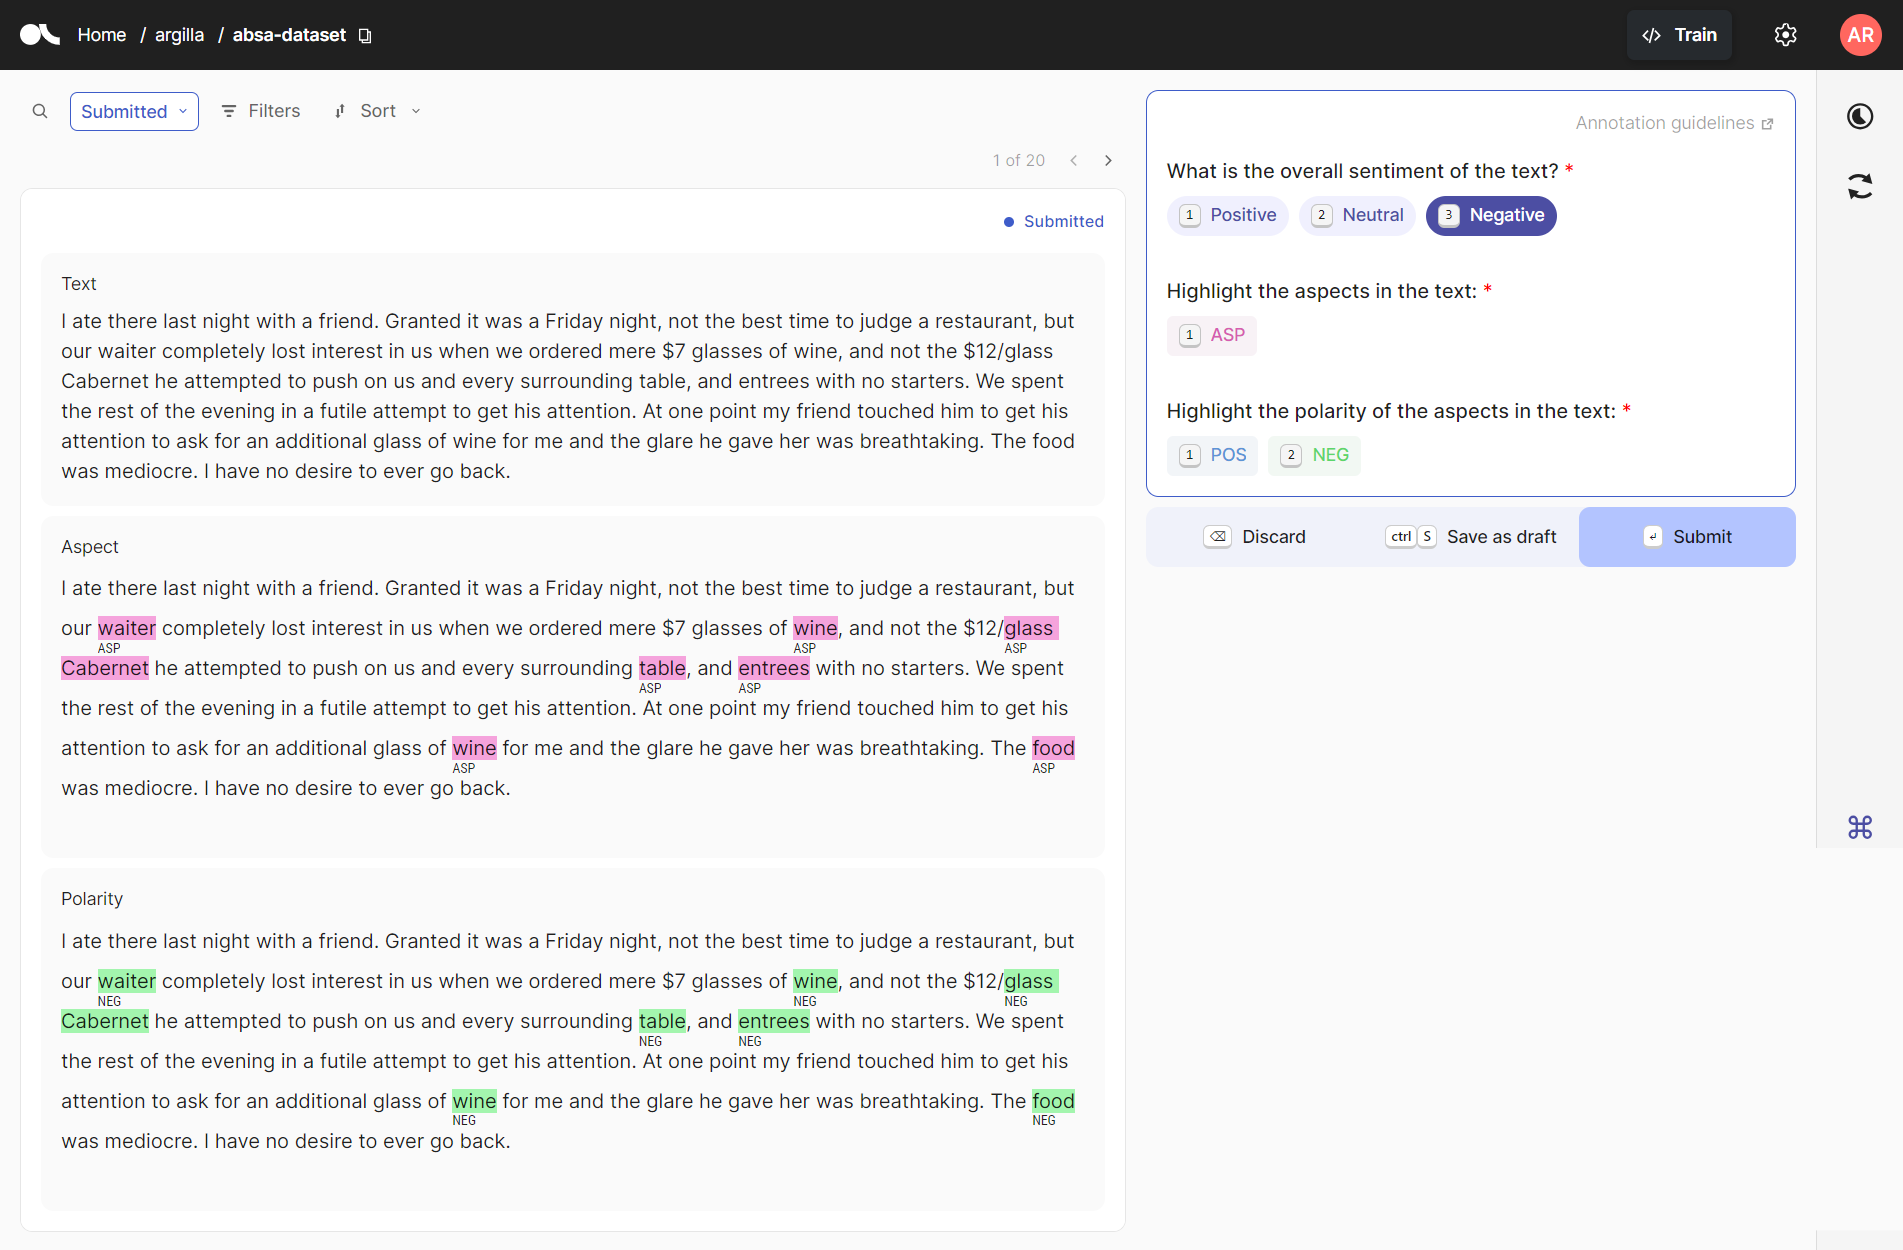

## (Extra) Formatting Annotations for Setfit ABSA

After obtaining the annotations, you can reformat them for use with Setfit ABSA, for example, to retrain the model incorporating these new annotations.

In our scenario, we'll proceed as if the predictions were accurate. Thus, we begin by retrieving the annotated dataset and focusing on the reviews that have been submitted.

In [27]:
# Retrieve the annotated dataset and filter the records
annotated_dataset = rg.FeedbackDataset.from_argilla(name="absa-dataset", workspace="argilla")
filtered_dataset = annotated_dataset.filter_by(response_status="submitted")

Finally, we'll loop through the records, formatting them for Setfit ABSA. Similar to our approach in the training phase, we'll replicate the reviews for each identified aspect and corresponding sentiment. During this process, we'll only take into account the aspects and their associated sentiments that match.

In [29]:
# Helper function to get the span text
def get_span_text(text, start, end):
    return text[start:end]

def prepare_absa_dataset(records):
    data = []
    for record in records:
        text = record.fields["text"]

        for response in record.responses:
            overall_sentiment = response.values["overall-sentiment"].value

            for aspect, polarity in zip(response.values["aspect"], response.values["polarity"]):
                
                for aspect_details, polarity_details in zip(aspect[1], polarity[1]):
                    if aspect_details.start == polarity_details.start and aspect_details.end == polarity_details.end:
                        aspect_text = get_span_text(text, aspect_details.start, aspect_details.end)
                        data.append({
                            "text": text,
                            "span": aspect_text,
                            "label": polarity_details.label,
                            "ordinal": calculate_ordinal(text, aspect_text, aspect_details.start),
                            "overall": overall_sentiment
                        })
    return data

In [30]:
# Formatting the data
records = filtered_dataset.records
absa_data = prepare_absa_dataset(records)

# Create the dataset
absa_dataset = Dataset.from_dict(list_dict_to_dict_list(absa_data))

In [32]:
absa_dataset.to_pandas().head()

,text,span,label,ordinal,overall
0,I'm spoiled when it comes to Chinese food beca...,food,POS,0,POS
1,I'm spoiled when it comes to Chinese food beca...,takeout order,POS,0,POS
2,I'm spoiled when it comes to Chinese food beca...,cashew chicken,POS,0,POS
3,I'm spoiled when it comes to Chinese food beca...,celery,POS,0,POS
4,I'm spoiled when it comes to Chinese food beca...,vegetable dumplings,POS,0,POS


## Conclusion

In this tutorial, we delved into the task of Aspect-Based Sentiment Analysis (ABSA) using Setfit ABSA and Argilla. Our journey began with adapting the dataset to the specific format, followed by fine-tuning the sentence transformers. We then proceeded to generate predictions using these models. To measure the effectiveness of our models, we used Argilla for performance evaluation. Our final step was to reformat the collected annotations to be compatible with Setfit ABSA, thus closing the loop of our ABSA workflow.